## Исследование объявлений о продаже квартир

**Цель исследования:**<br>
Определить рыночную стоимость объектов недвижимости. А также какие параметры в объявлении, влияют на цену объектов.<br>

Входные данные - данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных.<br>

**Описание:**<br>
Изучаем представленную информацию и приводим её в состояние пригодное для плноценного анализа: обрабатываем пропуски, дубликаты и аномальные значения.<br>
Далее проводим исследовательский анализ данных и устанавливаем параметры, влияющие на цену объектов.<br>
Исследование позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

## Чтение файла с данными и изучение общей информации

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Вывели первые строки, уже в них видны пропуски в данных.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В наборе данных всего 23699 строк.Обнаружены значительные пропуски в столбцах: 'ceiling_height', 'is_apartment', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition', а также неполные данные в колонках: 'floors_total', 'living_area', 'kitchen_area', 'locality_name'.
Также обнаружены проблемы с типами данных, в колонках 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition' - тип данных float, 'is_apartment', 'first_day_exposition' - тип данных object.

In [4]:
(data.isna().sum()/len(data)).round(4)*100

total_images             0.00
last_price               0.00
total_area               0.00
first_day_exposition     0.00
rooms                    0.00
ceiling_height          38.80
floors_total             0.36
living_area              8.03
floor                    0.00
is_apartment            88.29
studio                   0.00
open_plan                0.00
kitchen_area             9.61
balcony                 48.61
locality_name            0.21
airports_nearest        23.38
cityCenters_nearest     23.29
parks_around3000        23.28
parks_nearest           65.91
ponds_around3000        23.28
ponds_nearest           61.56
days_exposition         13.42
dtype: float64

Более наглядное представление, в процентах, количество пропусков в нашей исходной таблице.

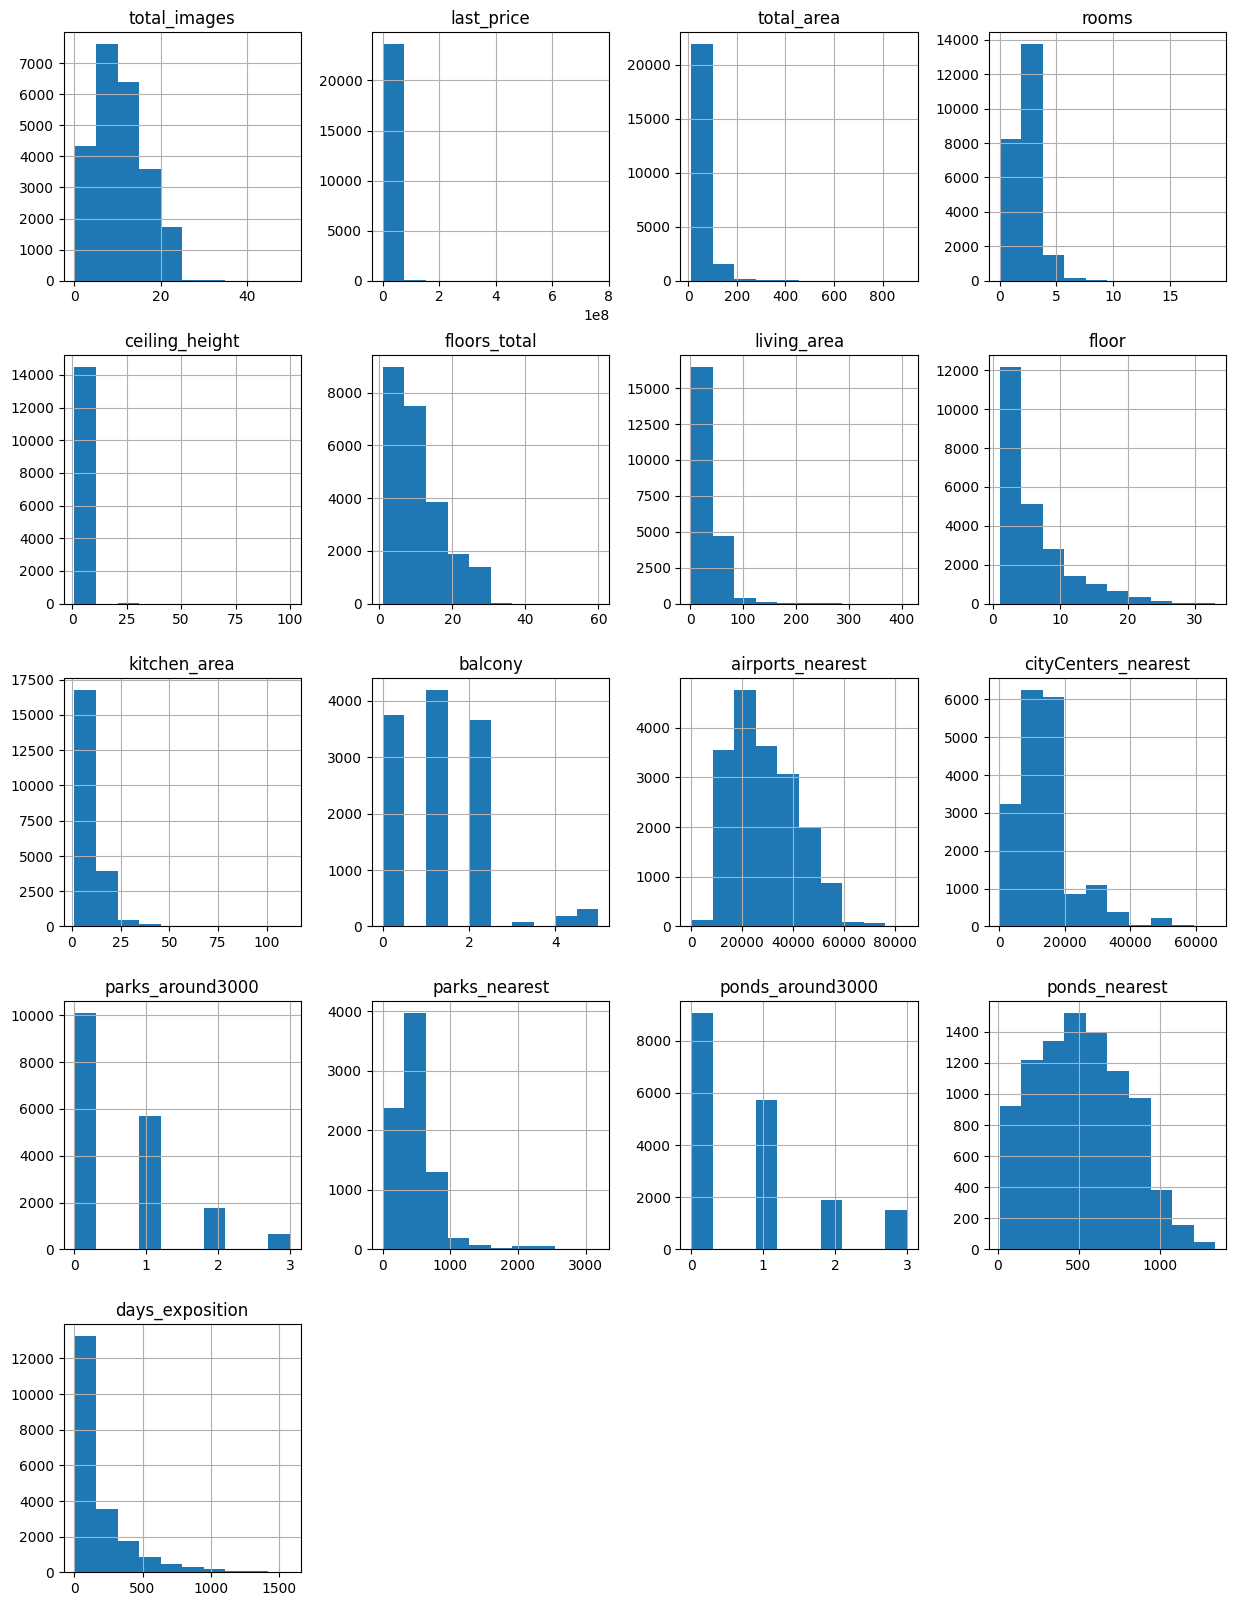

In [5]:
data.hist(figsize=(15, 20));

Построили гистограммы для каждого из числовых параметров нашей исходной таблицы для представления общей картины по исходным данным.

## Предобработка данных

Проверим наличие явных дубликабов.

In [6]:
data.duplicated().sum()

0

### Столбец 'ceiling_height'

Посчитаем количество пропусков в столбце 'ceiling_height'. И посмотрим на список характерных значений.

In [7]:
data['ceiling_height'].isnull().sum()

9195

In [8]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

В столбце 'ceiling_height' 9195 пропусков. Среднее значение 2.77 м и медиана 2.65 м. Сразу бросается в глаза максимальное значение 100 м и минимальная 1 м, что является аномальным в случае с высотой потолков. Посмотрим на значения в этом столбце, создадим сводную таблицу по высоте потолков и отсортируем по убыванию значений.

In [9]:
data_ceiling = data.pivot_table(index='ceiling_height', values='last_price', aggfunc='count').sort_values(by='ceiling_height', ascending=False)
data_ceiling.columns = ['count']
data_ceiling.head(10)

,count
ceiling_height,
100.0,1
32.0,2
27.5,1
27.0,8
26.0,1
25.0,7
24.0,1
22.6,1
20.0,1


Обнаружены аномальные значения. Высота потолков не может быть более 20 метров, если это только не дворец. Посмотрим на эти объявления.

In [10]:
data.query('ceiling_height > 11')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.0,55.2,2018-07-12T00:00:00,2,25.0,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,...,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,0,4300000.0,45.0,2018-02-01T00:00:00,2,25.0,9.0,30.0,2,NaN,...,7.0,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000.0,25.0,2017-09-27T00:00:00,0,27.0,25.0,17.0,17,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000.0,30.5,2018-10-03T00:00:00,1,24.0,5.0,19.5,1,True,...,5.5,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2500000.0,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,NaN,...,9.0,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5669,4,4400000.0,50.0,2017-08-08T00:00:00,2,26.0,9.0,21.3,3,NaN,...,7.0,2.0,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,NaN,...,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
6246,6,3300000.0,44.4,2019-03-25T00:00:00,2,25.0,5.0,31.3,5,NaN,...,5.7,NaN,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN
9379,5,3950000.0,42.0,2017-03-26T00:00:00,3,25.0,5.0,30.0,2,NaN,...,5.2,NaN,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN


Похоже что имеет место человеческий фактор, ошибка в порядках значений, когда укзывали высоту потолков.<br> 
Исправим аномальные значения, разделим значения больше 11 м на 10 и заменим их. Также удалим значения менее 2 м.

In [11]:
data = data.query('ceiling_height > 2 | ceiling_height.isna()')
data.loc[(data['ceiling_height'] > 11), 'ceiling_height'] = data['ceiling_height'] / 10

Заменили аномальные значения. Пропуски оставим без внимания, потому как параметр является индивидуальным для каждого объекта и заменить на медианное значение будет не корректно.

### Столбец 'is_apartment'

Рассмотрим следующий столбец с пропусками - 'is_apartment'. И посмотрим на список характерных значений.

In [12]:
data['is_apartment'].isna().sum()

20911

In [13]:
data['is_apartment'].describe()

count      2774
unique        2
top       False
freq       2724
Name: is_apartment, dtype: object

В столбце 'is_apartment' 20911 пропусков. Значения столбца представляют категоральные значения False и True. Посмотрим на количество значений.

In [14]:
data_is_apartment = data.pivot_table(index='is_apartment', values='last_price', aggfunc='count').sort_values(by='is_apartment', ascending=False)
data_is_apartment.columns = ['count']
data_is_apartment

,count
is_apartment,
True,50
False,2724


Пропуски в столбце говорят о том, что недвижимость скорее всего не является апартаментами, в таком случае пропуски заполним значением 'False'. А также поменяем тип данных в столбце с object на bool.

In [15]:
data['is_apartment'].fillna(value=False, inplace=True)
data['is_apartment'] = data['is_apartment'].astype('bool')
data['is_apartment'].isna().sum()

0

Проверили наличие пропусков после их замены на значение 'False'.

### Столбец 'balcony'

Переходим к следующему столбцу - 'balcony'. И посмотрим на список характерных значений.

In [16]:
data['balcony'].isna().sum()

11509

In [17]:
data['balcony'].describe()

count    12176.000000
mean         1.150131
std          1.071396
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64

В столбце 'balcony' 11509 пропусков. Посмотрим на значения столбца.

In [18]:
data_balcony = data.pivot_table(index='balcony', values='last_price', aggfunc='count').sort_values(by='balcony', ascending=False)
data_balcony.columns = ['count']
data_balcony

,count
balcony,
5.0,304
4.0,183
3.0,81
2.0,3658
1.0,4193
0.0,3757


Значения представляют количество балконов от 0 до 5. Пропуски в столбце говорят о том, что балконов скорее всего нет. Поэтому пропуски заменим на значение 0. А также поменяем тип данных с float на int.

In [19]:
data['balcony'].fillna(value=0, inplace=True)
data['balcony'] = data['balcony'].astype('int')
data['balcony'].isna().sum()

0

Проверили наличие пропусков после их замены.

### Столбец 'airports_nearest'

Переходим к следующему столбцу - 'airports_nearest'. Посмотрим на список характерных значений.

In [20]:
data['airports_nearest'].isna().sum()

5533

In [21]:
data['airports_nearest'].describe()

count    18152.000000
mean     28793.370758
std      12632.072427
min          0.000000
25%      18582.000000
50%      26726.000000
75%      37273.500000
max      84869.000000
Name: airports_nearest, dtype: float64

В столбце 'airports_nearest' 5533 пропуска. Значения представляют расстояние до аэропорта в метрах и находятся в диапазоне от 0 до 84869 м. Сгруппируем и посмотрим на значения столбца.

In [22]:
data_airports_nearest = data.pivot_table(index='airports_nearest', values='last_price', aggfunc='count').sort_values(by='airports_nearest', ascending=False)
data_airports_nearest.columns = ['count']
data_airports_nearest

,count
airports_nearest,
84869.0,1
84853.0,1
84665.0,1
84006.0,1
83758.0,1
...,...
6989.0,6
6949.0,1
6914.0,1


Пропуски могли получиться по технической причине, так как исходя из описания исследования — эти данные автоматически получены из геосервисов. Также возможная проблема могла появиться в следствие неправильно указанных адресов в объявлении.<br>

### Столбец 'cityCenters_nearest'

Переходим к следующему столбцу - 'cityCenters_nearest'. Посмотрим на список характерных значений.

In [23]:
data['cityCenters_nearest'].isna().sum()

5510

In [24]:
data['cityCenters_nearest'].describe()

count    18175.000000
mean     14190.721816
std       8608.767879
min        181.000000
25%       9238.000000
50%      13098.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

В столбце 'cityCenters_nearest' 5510 пропусков. Значения представляют расстояние до центра города в метрах и находятся в диапазоне от 181 до 65968 м. Сгруппируем и посмотрим на значения столбца.

In [25]:
data_cityCenters_nearest = data.pivot_table(index='cityCenters_nearest', values='last_price', aggfunc='count').sort_values(by='cityCenters_nearest', ascending=False)
data_cityCenters_nearest.columns = ['count']
data_cityCenters_nearest

,count
cityCenters_nearest,
65968.0,1
65952.0,1
65764.0,1
65105.0,1
64857.0,1
...,...
291.0,1
287.0,1
215.0,1


Причина пропусков та же, что и в предыдущем столбце.<br>

### Столбец 'parks_around3000'

Переходим к следующему столбцу - 'parks_around3000'. Посмотрим на список характерных значений.

In [26]:
data['parks_around3000'].isna().sum()

5509

In [27]:
data['parks_around3000'].describe()

count    18176.000000
mean         0.611356
std          0.802082
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

В столбце 'parks_around3000' 5509 пропусков. Значения представляют количество парков в радиусе 3 км и находятся в диапазоне от 0 до 3. Тип данных float необходимо заменить на int, потому что количество парков не может быть вещественным числом. Сгруппируем и посмотрим на значения столбца.

In [28]:
data_parks_around3000 = data.pivot_table(index='parks_around3000', values='last_price', aggfunc='count').sort_values(by='parks_around3000', ascending=False)
data_parks_around3000.columns = ['count']
data_parks_around3000

,count
parks_around3000,
3.0,647
2.0,1746
1.0,5679
0.0,10104


Пропуски в столбце говорят о том, что парков скорее всего нет. Поэтому пропуски заменим на значение 0. Поменять тип данных с float на int не получится, потому как в столбце есть пропуски в значениях.<br>
Причина пропусков такая же как в предыдущем столбце, так как данные были получены автоматически из геоинформационных систем.

### Столбец 'parks_nearest'

Переходим к следующему столбцу - 'parks_nearest'. Посмотрим на список характерных значений.

In [29]:
data['parks_nearest'].isna().sum()

15609

In [30]:
data['parks_nearest'].describe()

count    8076.000000
mean      490.815874
std       342.373269
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

В столбце 'parks_nearest' 15609 пропусков. Значения представляют расстояние до ближайшего парка и находятся в диапазоне от 1 до 3190 м.  Сгруппируем и посмотрим на значения столбца.

In [31]:
data_parks_nearest = data.pivot_table(index='parks_nearest', values='last_price', aggfunc='count').sort_values(by='parks_nearest', ascending=False)
data_parks_nearest.columns = ['count']
data_parks_nearest

,count
parks_nearest,
3190.0,2
3064.0,1
3013.0,1
2984.0,1
2905.0,1
...,...
9.0,2
7.0,1
4.0,1


Пропуски в столбце говорят о том, что парков рядом скорее всего нет.<br>
Причина пропусков такая же как в предыдущем столбце, так как данные были получены автоматически из геоинформационных систем.

### Столбец 'ponds_around3000'

Переходим к следующему столбцу - 'ponds_around3000'. Посмотрим на список характерных значений.

In [32]:
data['ponds_around3000'].isna().sum()

5509

In [33]:
data['ponds_around3000'].describe()

count    18176.000000
mean         0.770081
std          0.938264
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

В столбце 'ponds_around3000' 5509 пропусков. Значения представляют количество водоёмов в радиусе 3 км и находятся в диапазоне от 0 до 3. Тип данных float - есть пропуски в значениях. Сгруппируем и посмотрим на значения столбца.

In [34]:
data_ponds_around3000 = data.pivot_table(index='ponds_around3000', values='last_price', aggfunc='count').sort_values(by='ponds_around3000', ascending=False)
data_ponds_around3000.columns = ['count']
data_ponds_around3000

,count
ponds_around3000,
3.0,1500
2.0,1891
1.0,5715
0.0,9070


Пропуски в столбце говорят о том, что водоёмов скорее всего нет. Причина пропусков такая же как в предыдущем столбце, так как данные были получены автоматически из геоинформационных систем.

### Столбец 'ponds_nearest'

Переходим к следующему столбцу - 'ponds_nearest'. Посмотрим на список характерных значений.

In [35]:
data['ponds_nearest'].isna().sum()

14579

In [36]:
data['ponds_nearest'].describe()

count    9106.000000
mean      518.046782
std       277.670405
min        13.000000
25%       294.000000
50%       502.000000
75%       729.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

В столбце 'ponds_nearest' 14579 пропусков. Значения представляют расстояние до ближайшего водоёма и находятся в диапазоне от 13 до 1344 м.  Сгруппируем и посмотрим на значения столбца.

In [37]:
data_ponds_nearest = data.pivot_table(index='ponds_nearest', values='last_price', aggfunc='count').sort_values(by='ponds_nearest', ascending=False)
data_ponds_nearest.columns = ['count']
data_ponds_nearest

,count
ponds_nearest,
1344.0,1
1341.0,2
1337.0,1
1313.0,1
1299.0,1
...,...
22.0,7
20.0,5
19.0,4


Пропуски в столбце говорят о том, что водоёмов рядом скорее всего нет.<br>
Причина пропусков такая же как в предыдущем столбце, так как данные были получены автоматически из геоинформационных систем.

### Столбец 'days_exposition'

Переходим к следующему столбцу - 'days_exposition'. Посмотрим на список характерных значений.

In [38]:
data['days_exposition'].isna().sum()

3178

In [39]:
data['days_exposition'].describe()

count    20507.000000
mean       180.927830
std        219.768049
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

В столбце 'days_exposition' 3178 пропусков. Значения представляют кличество дней которое было размещено объявление и находятся в диапазоне от 1 до 1580 дней.  Сгруппируем и посмотрим на значения столбца.

In [40]:
data_days_exposition = data.pivot_table(index='days_exposition', values='last_price', aggfunc='count').sort_values(by='days_exposition', ascending=False)
data_days_exposition.columns = ['count']
data_days_exposition

,count
days_exposition,
1580.0,1
1572.0,1
1553.0,1
1513.0,1
1512.0,2
...,...
5.0,152
4.0,176
3.0,158


Пропуски в столбце говорят о том, что скорее всего объявление ещё действующее. Поменять тип данных с float на int не получится, потому что присутствуют пропуски.

### Столбец 'floors_total'

In [41]:
data['floors_total'].isna().sum()

86

In [42]:
data['floors_total'].describe()

count    23599.000000
mean        10.673842
std          6.595522
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

В столбце 'floors_total' всего 86 пропусков. Значения представляют собой количество этажей в доме. Заполним пропуски номером этажа. И поменяем тип данных float на int, потому что количество этажей не может быть вещественным числом.

In [43]:
data.loc[data['floors_total'].isna(), 'floors_total'] = data['floor']
data['floors_total'] = data['floors_total'].astype('int')
data['floors_total'].isna().sum()

0

Проверили наличие пропусков после их замены.

### Столбцы 'living_area', 'kitchen_area', 'first_day_exposition'

In [44]:
data['living_area'].isna().sum()

1901

In [45]:
data['living_area'].describe()

count    21784.000000
mean        34.461662
std         22.033201
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

В столбце 'living_area' 1901 пропуск.

In [46]:
data['total_area'].median() / data['living_area'].median()

1.7333333333333334

Нашли коэффициент, который показывает во сколько раз жилая площадь меньше общей. Заполним пропуски в столбце 'living_area' разделив общую площадь на коэффициент 1.73.

In [47]:
data.loc[(data['living_area'].isna()), 'living_area'] = (data['total_area'] / 1.73)
data['living_area'] = data['living_area'].round(2)

In [48]:
data['kitchen_area'].isna().sum()

2276

In [49]:
data['kitchen_area'].describe()

count    21409.000000
mean        10.571026
std          5.906616
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

В столбце 'kitchen_area' 2276 пропусков.

Обработаем тип данных в столбце 'first_day_exposition' для изменения типа данных на datetime.

In [50]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [51]:
data['first_day_exposition']

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23685, dtype: datetime64[ns]

Мы изменили тип столбца на datetime для проведения дальнейшего исследования.

### Столбец 'locality_name'

In [52]:
data['locality_name'].isna().sum()

49

In [53]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

В столбце 'locality_name' 49 пропусков. Значения столбца представляют названия населенных пунктов в которых находятся объекты недвижимости. В значениях встречаются неявные дубликаты, которые необходимо привести к единому названию.

In [54]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е').replace(['поселок городского типа', 'городской поселок', 'поселок станции', 'поселок при железнодорожной станции', 'коттеджный поселок'], 'поселок', regex=True)

In [55]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка

**Вывод:**<br>
Таким образом мы просмотрели значения столбцов 'is_apartment', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition', в которых было значительное количество пропусков и обработали их.<br>
Пропуски в 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest' оставили без изменений.<br>
Пропуски в 'floors_total' заполнили значениями из 'floor'. В столбце 'ceiling_height' удалили аномальные значения, в столбце 'living_area' пропуски заполнили путем выведения соотношения общей площади к жилой, 'kitchen_area' пропуски не заполняли. В столбце 'locality_name' заменили неявные дубдикаты.<br>
Изменили типы данных, в колонках 'floors_total', 'balcony', 'days_exposition' - на тип данных int, 'is_apartment' - на тип данных bool, 'first_day_exposition' - на тип данных datetime.
Заполнение пропусков, а также изменение типов данных необходимо для применения нужных методов и функций при обработке данных для проведения анализа.

## Добавляем необходимые  столбцы в таблицу

Для начала проведения исследования добавим необходимые дополнительные столбцы.

In [56]:
data['price_metre']  = (data['last_price'] / data['total_area']).round(2)
data['day_week_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

Создали дополнительные столбцы 'price_metre' - цена квадратного метра, 'day_week_exposition' - день недели публикации объявления, 'month_exposition' - месяц публикации объявления, 'year_exposition' - год публикации объявления.

In [57]:
import numpy as np
conditions = [data['floor'] == data['floors_total'], data['floor'] == 1]
choices = ['последний','первый']
data['floor_type'] = np.select(conditions, choices, default='другой')
data['floor_type']

0        другой
1        первый
2        другой
3        другой
4        другой
          ...  
23694    другой
23695    другой
23696    первый
23697    другой
23698    первый
Name: floor_type, Length: 23685, dtype: object

Создали столбец 'floor_type' - тип этажа, который принимает категоральные значения: первый, последний, другой.

In [58]:
data['cityCenters_km'] = (data['cityCenters_nearest'] / 1000).round()

Создали столбец 'cityCenters_km' - расстояние до центра города в километрах.

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23685 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23685 non-null  int64         
 1   last_price            23685 non-null  float64       
 2   total_area            23685 non-null  float64       
 3   first_day_exposition  23685 non-null  datetime64[ns]
 4   rooms                 23685 non-null  int64         
 5   ceiling_height        14490 non-null  float64       
 6   floors_total          23685 non-null  int32         
 7   living_area           23685 non-null  float64       
 8   floor                 23685 non-null  int64         
 9   is_apartment          23685 non-null  bool          
 10  studio                23685 non-null  bool          
 11  open_plan             23685 non-null  bool          
 12  kitchen_area          21409 non-null  float64       
 13  balcony              

Мы создали необходимые столбцы. Теперь можем приступать к проведению нашего исследования. 

## Проведение исследовательского анализа данных

### Изучаем параметр 'total_area'

Начнем проведение исследования с изучения отдельных параметров нашей выборки.

In [60]:
data['total_area'].describe()

count    23685.000000
mean        60.356916
std         35.661177
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

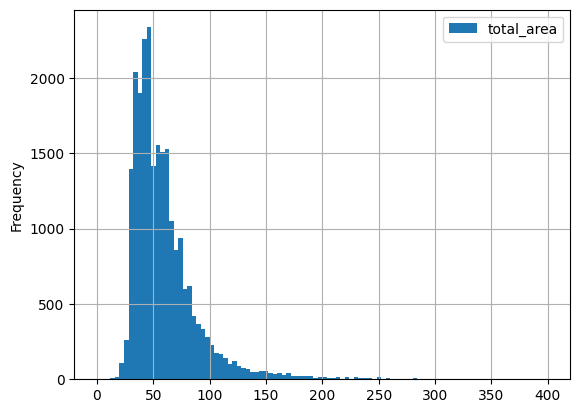

In [61]:
data.plot(y='total_area', kind='hist', range=(0, 400), bins=(100), grid=True);

Гистограмма общей площади имеет разброс значений от 12 до 900 м с пиком значений 48 м, в диапазоне 60-75 м резко падает, а после 120 м стремится к нулю. Значения более 200 м будут мешать объективному анализу. Оценим количество таких объявлений.

In [62]:
len(data.query('total_area > 200')) / len(data)

0.00958412497361199

Недвижимость общей площадью более 200 м составляют менее 1% нашей выборки. Очистим её от этих значений. 

In [63]:
data_normal = data.query('total_area < 200')

Сохранили очищенные данные в data_normal.

### Изучаем параметр 'living_area'

In [64]:
data['living_area'].describe()

count    23685.000000
mean        34.634616
std         22.390314
min          2.000000
25%         19.000000
50%         30.000000
75%         42.200000
max        409.700000
Name: living_area, dtype: float64

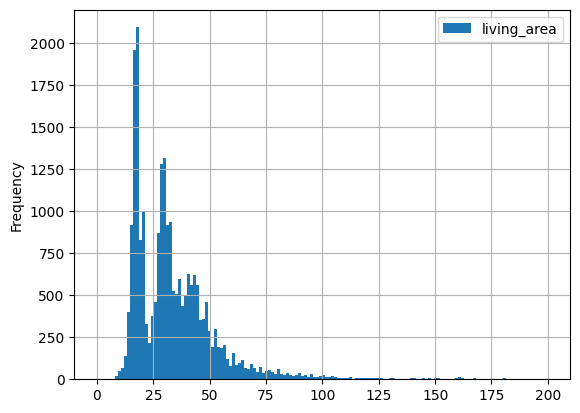

In [65]:
data.plot(y='living_area', kind='hist', range=(0, 200), bins=(150), grid=True);

Гистограмма жилой площади имеет разброс значений от 2 до 409 м, с первым пиком значений около 15 м и вторым пиком поменьше на 27 м, резко уменьшается после 45 м, а после 75 м уже незначительна и близка к нулю. Значения более 100 м будут мешать объективному анализу. Оценим количество таких объявлений.

In [66]:
len(data.query('living_area > 100')) / len(data)

0.01680388431496728

Чуть более полутора процентов от исходной выборки. Очистим data_normal от этих значений.

In [67]:
data_normal = data_normal.query('living_area <= 100')

### Изучаем параметр 'kitchen_area'

In [68]:
data['kitchen_area'].describe()

count    21409.000000
mean        10.571026
std          5.906616
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

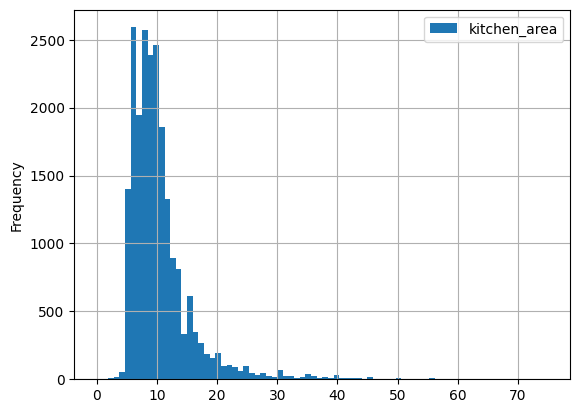

In [69]:
data.plot(y='kitchen_area', kind='hist', range=(0, 75), bins=(80), grid=True);

Гистограмма площади кухни имеет разброс значений от 1.3 м до 112 м, с пиком около 8 м, резко уменьшается после 11 м, а после 20 м уже незначительна и близка к нулю. Очистим нашу выборку от экстримальных значений.

In [70]:
len(data.query('(kitchen_area > 35) | (kitchen_area < 3)')) / len(data)

0.00958412497361199

Значений с площадь кухни более 35 м и менее 3 м оказалось менее 1% от исходной выборки. Очистим нашу выборку data_normal.

In [71]:
data_normal = data_normal.query('3 < kitchen_area <= 35')

### Изучаем параметр 'last_price'

In [72]:
data['last_price'].describe()

count    2.368500e+04
mean     6.543382e+06
std      1.088977e+07
min      1.219000e+04
25%      3.413000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

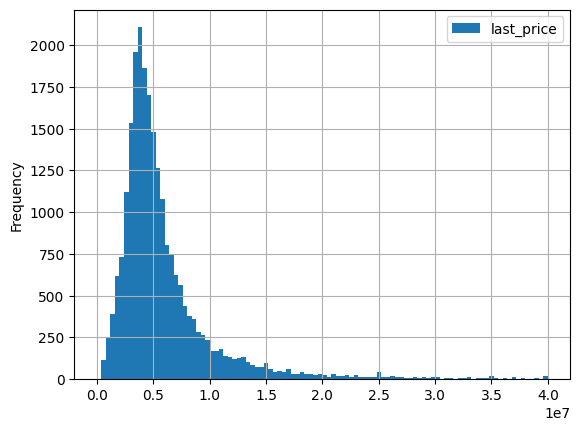

In [73]:
data.plot(y='last_price', kind='hist', range=(0, 40000000), bins=(100), grid=True);

Гистограмма цены недвижимости имеет разброс значений от 12190 до 763 000 000, с пиком значений около 4 000 000, а после 20 000 000 уже близки к нулю. Значения менее 100 000 выглядят подозрительно и скорее всего являются ошибкой оператора - человеческий фактор. Посмотрим на эти значения

In [74]:
data.query('last_price <= 100000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metre,day_week_exposition,month_exposition,year_exposition,floor_type,cityCenters_km
8793,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,False,...,805.0,0.0,NaN,8.0,111.83,2,3,2019,последний,9.0


Всего одно значение. Умножим его на 1000.

In [75]:
data.loc[8793, 'last_price'] = data.loc[8793, 'last_price'] * 1000
data.query('last_price <= 100000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metre,day_week_exposition,month_exposition,year_exposition,floor_type,cityCenters_km


### Изучаем параметр 'rooms'

In [76]:
data['rooms'].describe()

count    23685.000000
mean         2.070847
std          1.078515
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

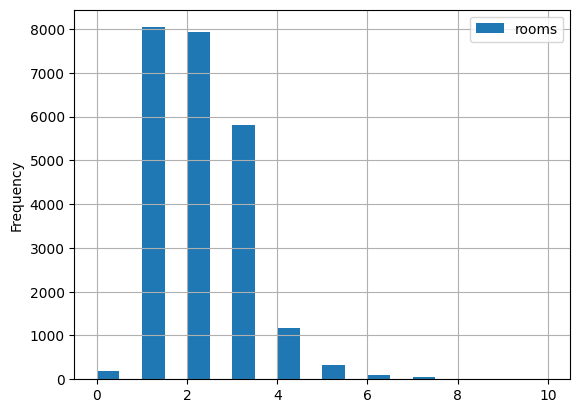

In [77]:
data.plot(y='rooms', kind='hist', range=(0, 10), bins=(20), grid=True);

Гистограмма количества комнат имеет разброс значений от 0 до 19, больше всего, что логичкно 1, 2 и 3 комнатных квартир.<br>
Присутствуют значения 0, что выглядит аномально, хотя возможно это студии или квартиры со свободной планировкой. Необходимо проверить.

In [78]:
data.query('rooms == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metre,day_week_exposition,month_exposition,year_exposition,floor_type,cityCenters_km
144,1,2450000.0,27.00,2017-03-30,0,NaN,24,15.50,2,False,...,NaN,NaN,NaN,181.0,90740.74,3,3,2017,другой,NaN
349,4,2320000.0,25.00,2017-09-27,0,NaN,14,17.00,1,False,...,NaN,NaN,NaN,45.0,92800.00,2,9,2017,первый,NaN
440,8,2480000.0,27.11,2018-03-12,0,NaN,17,24.75,4,False,...,NaN,2.0,982.0,64.0,91479.16,0,3,2018,другой,15.0
508,0,3375000.0,34.40,2017-03-28,0,NaN,26,24.30,19,False,...,NaN,1.0,593.0,430.0,98110.47,1,3,2017,другой,19.0
608,2,1850000.0,25.00,2019-02-20,0,NaN,10,14.45,7,False,...,NaN,NaN,NaN,29.0,74000.00,2,2,2019,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01,0,NaN,25,18.00,16,False,...,NaN,1.0,623.0,14.0,123076.92,4,9,2017,другой,13.0
23442,0,2500000.0,27.70,2017-09-28,0,NaN,24,18.00,4,False,...,NaN,NaN,NaN,4.0,90252.71,3,9,2017,другой,NaN
23554,15,3350000.0,26.00,2018-09-07,0,NaN,19,15.03,8,False,...,NaN,2.0,112.0,31.0,128846.15,4,9,2018,другой,17.0
23592,10,1450000.0,29.00,2017-11-11,0,NaN,9,18.00,8,False,...,NaN,NaN,NaN,82.0,50000.00,5,11,2017,другой,NaN


Всего 197 таких объявлений.

In [79]:
data['open_plan'].value_counts()

open_plan
False    23618
True        67
Name: count, dtype: int64

Со свободной планировкой всего 67 квартир.

In [80]:
data[(data['open_plan'] == True)].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metre,day_week_exposition,month_exposition,year_exposition,floor_type,cityCenters_km
349,4,2320000.0,25.00,2017-09-27,0,NaN,14,17.00,1,False,...,NaN,NaN,NaN,45.0,92800.00,2,9,2017,первый,NaN
508,0,3375000.0,34.40,2017-03-28,0,NaN,26,24.30,19,False,...,NaN,1.0,593.0,430.0,98110.47,1,3,2017,другой,19.0
780,9,2600000.0,26.10,2018-02-20,0,NaN,18,15.09,8,False,...,NaN,NaN,NaN,45.0,99616.86,1,2,2018,другой,NaN
839,14,1900000.0,35.00,2017-04-14,0,2.7,5,15.00,3,False,...,NaN,NaN,NaN,7.0,54285.71,4,4,2017,другой,NaN
946,5,2200000.0,23.00,2016-09-27,0,NaN,27,18.00,7,False,...,NaN,NaN,NaN,483.0,95652.17,1,9,2016,другой,NaN
1379,3,6000000.0,44.20,2015-11-10,1,NaN,25,17.40,23,False,...,NaN,0.0,NaN,231.0,135746.61,1,11,2015,другой,13.0
1574,0,2200000.0,22.00,2017-11-03,0,NaN,18,15.00,16,False,...,NaN,NaN,NaN,81.0,100000.00,4,11,2017,другой,NaN
1625,7,1980000.0,23.98,2018-02-01,0,NaN,4,10.50,3,False,...,NaN,NaN,NaN,120.0,82568.81,3,2,2018,другой,NaN
2532,5,3500000.0,27.10,2018-02-01,0,NaN,18,18.70,9,False,...,NaN,1.0,644.0,70.0,129151.29,3,2,2018,другой,8.0
3019,18,2100000.0,24.00,2017-11-10,0,NaN,10,18.00,6,False,...,NaN,NaN,NaN,5.0,87500.00,4,11,2017,другой,NaN


Посмотрели на первые 10 строк с параметром свободной планировки True. Есть значение в столбце 'rooms' с одной комнатой, поэтому гипотеза не подтвердилась.

In [81]:
data['studio'].value_counts()

studio
False    23536
True       149
Name: count, dtype: int64

Всего 149 студий.

In [82]:
data[(data['studio'] == True)].head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metre,day_week_exposition,month_exposition,year_exposition,floor_type,cityCenters_km
144,1,2450000.0,27.00,2017-03-30,0,NaN,24,15.50,2,False,...,NaN,NaN,NaN,181.0,90740.74,3,3,2017,другой,NaN
440,8,2480000.0,27.11,2018-03-12,0,NaN,17,24.75,4,False,...,NaN,2.0,982.0,64.0,91479.16,0,3,2018,другой,15.0
608,2,1850000.0,25.00,2019-02-20,0,NaN,10,14.45,7,False,...,NaN,NaN,NaN,29.0,74000.00,2,2,2019,другой,NaN
697,12,2500000.0,24.10,2017-12-01,0,2.75,25,17.50,21,False,...,NaN,NaN,NaN,201.0,103734.44,4,12,2017,другой,NaN
716,5,1500000.0,17.00,2017-06-07,0,2.70,9,12.00,1,False,...,NaN,0.0,NaN,40.0,88235.29,2,6,2017,первый,30.0
1173,12,3240000.0,29.00,2018-10-30,0,NaN,24,17.00,2,False,...,NaN,1.0,475.0,13.0,111724.14,1,10,2018,другой,16.0
1174,3,3900000.0,32.00,2016-10-18,0,2.70,24,18.00,2,False,...,609.0,0.0,NaN,540.0,121875.00,1,10,2016,другой,8.0
1220,5,3300000.0,27.00,2017-11-10,0,2.80,17,20.00,16,False,...,NaN,1.0,528.0,113.0,122222.22,4,11,2017,другой,12.0
1260,0,2600000.0,27.00,2018-07-20,0,2.70,16,16.00,4,False,...,NaN,NaN,NaN,102.0,96296.30,4,7,2018,другой,NaN
1277,10,3150000.0,26.00,2017-07-14,0,2.75,21,17.38,11,False,...,NaN,0.0,NaN,622.0,121153.85,4,7,2017,другой,17.0


Посмотрели на первые 20 строк с параметром студии True. Есть значение в столбце 'rooms' с одной комнатой, поэтому гипотеза также не подтвердилась.<br>
В большинстве своем с количеством комнат 0 оказазались квартиры студии или со свободной планировкой, но эта гипотеза относится не ко всем квартирам.<br>
Также имеются квартиры в которых 6 и более комнат, которые могут повлиять на наше исследование. Оценим количество таких объявлений.

In [83]:
len(data.query('rooms > 5')) / len(data)

0.008233058898036731

Таких объявлений менее 1%. Очистим data_normal  от них.

In [84]:
data_normal = data_normal.query('rooms <= 5')

### Изучаем параметр 'ceiling_height'

In [85]:
data['ceiling_height'].describe()

count    14490.000000
mean         2.729585
std          0.304827
min          1.400000
25%          2.520000
50%          2.650000
75%          2.800000
max         10.300000
Name: ceiling_height, dtype: float64

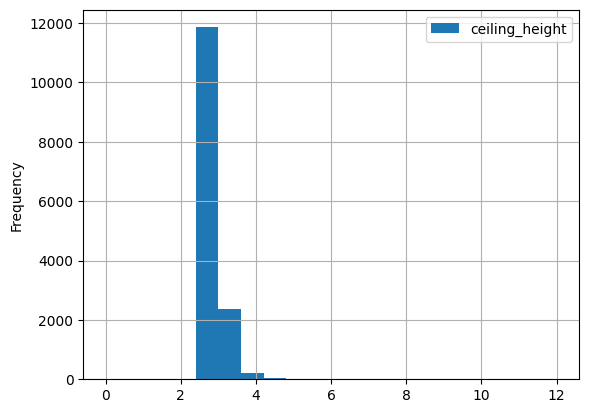

In [86]:
data.plot(y='ceiling_height', kind='hist', range=(0, 12), bins=(20), grid=True);

Высота потолков имеет разброс значений от 2.2 м до 10.3 м.<br>

### Изучаем параметр 'floor_type'

In [87]:
data['floor_type'].value_counts()

floor_type
другой       17354
последний     3445
первый        2886
Name: count, dtype: int64

Параметр является категоральным, в нем три значения. Больше всего любых других этажей кроме первого и последнего, что логично, далее последние этажи и первые этажи.

### Изучаем параметр 'floors_total'

In [88]:
data['floors_total'].describe()

count    23685.000000
mean        10.671480
std          6.594156
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

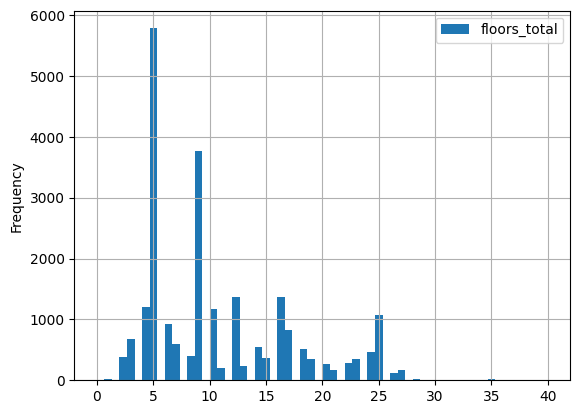

In [89]:
data.plot(y='floors_total', kind='hist', range=(0, 40), bins=(60), grid=True);

Гистограмма общее количество этажей в доме имеет разброс значений от 1 до 60.<br>
Больше всего 5 и 9 этажных домов.

### Изучаем параметр 'cityCenters_nearest'

In [90]:
data['cityCenters_nearest'].describe()

count    18175.000000
mean     14190.721816
std       8608.767879
min        181.000000
25%       9238.000000
50%      13098.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

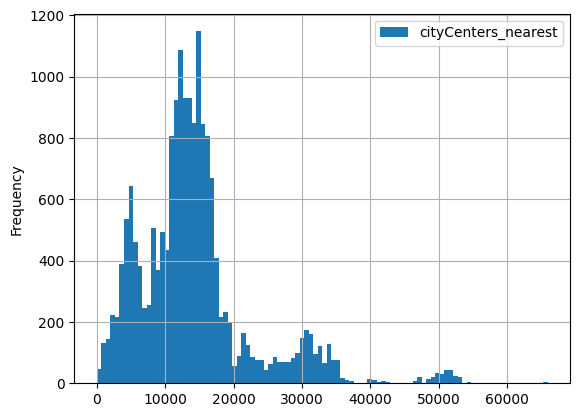

In [91]:
data.plot(y='cityCenters_nearest', kind='hist', range=(0, 66000), bins=(100), grid=True);

Гистограмма расстояние до центра города имеет несколько пиковых значений около 5000 м и 12000 м.<br>
Значительно меньше значений в диапазоне 20 000 - 36 000 м, а после 40 000 м их почти уже нет.

### Изучаем параметр 'parks_nearest'

In [92]:
data['parks_nearest'].describe()

count    8076.000000
mean      490.815874
std       342.373269
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

<Axes: ylabel='Frequency'>

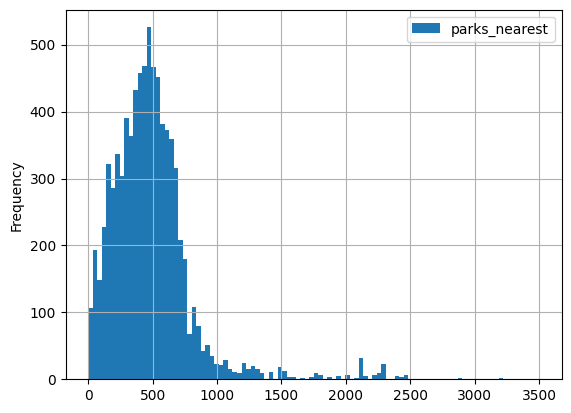

In [93]:
data.plot(y='parks_nearest', kind='hist', range=(0, 3500), bins=(100), grid=True)

Гистограмма расстояние до ближайшего парка имеет пиковое значение около 500 м.<br>
Резко падает после 700 м, а после 1000 м количество значений уже незначительно.

### Изучаем параметр 'days_exposition'

In [94]:
data['days_exposition'].describe()

count    20507.000000
mean       180.927830
std        219.768049
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

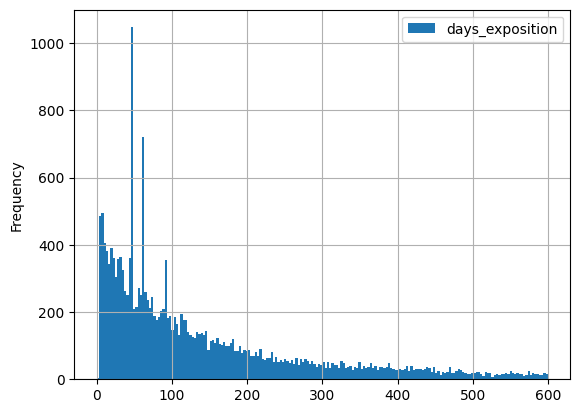

In [95]:
data.plot(y='days_exposition', kind='hist', range=(0, 600), bins=(200), grid=True);

Гистограмма имеет разброс значений от 1 до 1580 дней, с пиковыми значениями около 45 дней и 69 дней, далее по гипотенузе стремится к нулю после 600.

In [96]:
data_not_null_days_exposition = data.query('days_exposition != 0')
data_not_null_days_exposition['days_exposition'].mean()

180.92782952162676

In [97]:
data_not_null_days_exposition['days_exposition'].median()

95.0

Среднее арифметическое получилось 181 день, а медиана 95 дней. <br>
Проанализировав гистограмму, значения среднего арифметического и медианы, получается, что обычно продажа происходит в диапазоне 40 - 100 дней. Следовательно значения менее 40 дней можно считать быстрой продажей, а значения более 600 дней, т.е. почти 2 года, уже необычно долгой продажей.
Два пиковых значения возможно связаны с регламентом работы банков или застройщиков, т.е. участников сделки по купле-продаже.

Мы изучили некоторые параметры объектов и построили отдельные гистограммы для каждого из этих параметров. В некоторых параметрах встретились редкие и выбивающиеся значения, которые мы очистили из исходной таблицы и сохранили в data_normal.

## Определяем параметры, которые больше всего влияют на стоимость объекта.

### Зависимость стоимости от 'total_area'

При определении зависимости стоимости от параметров недвижимости будем использовать очищенную от выдающихся значений таблицу data_normal.<br>
Посмотрим сколько значений осталось в ней по сравнению с исходной.

In [98]:
len(data_normal)/len(data)

0.8795440151994933

12% объявлений оказались с выдающимися значениями. 88% вполне хороший результат.

In [99]:
data_normal['last_price'].corr(data_normal['total_area'])

0.6677852084980009

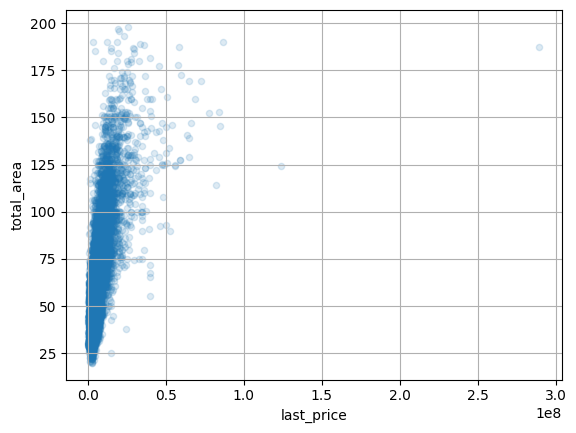

In [100]:
data_normal.plot(x='last_price', y='total_area', kind='scatter', alpha=0.15, grid=True);

По графику и значению коэффициента корреляции можно сделать вывод о прямопропорциональной зависимости. Т.е. при увеличении общей площади - стоимость тоже увеличивается.

### Зависимость стоимости от 'living_area'

In [101]:
data_normal['last_price'].corr(data_normal['living_area'])

0.557065609496137

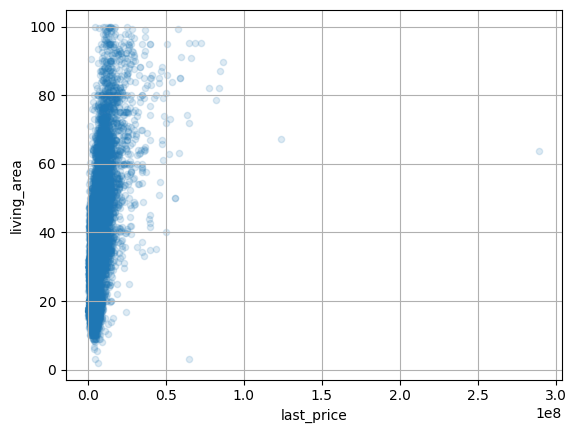

In [102]:
data_normal.plot(x='last_price', y='living_area', kind='scatter', alpha=0.15, grid=True);

По графику и значению коэффициента корреляции можно также сделать вывод о прямопропорциональной зависимости, но не такой уже сильной, как в общей площади. Т.е. при увеличении жилой площади - стоимость тоже увеличивается.

### Зависимость стоимости от 'kitchen_area'

In [103]:
data_normal['last_price'].corr(data_normal['kitchen_area'])

0.4896850525051898

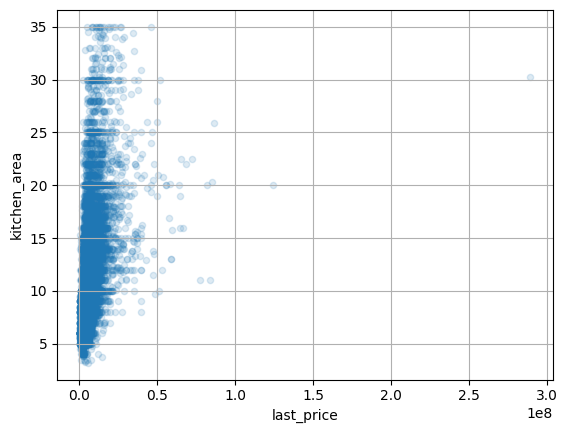

In [104]:
data_normal.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.15, grid=True);

По графику и значению коэффициента корреляции можно также сделать вывод о ещё меньшей прямопропорциональной зависимости от площади кухни. Т.е. при увеличении площади кухни -  стоимость недвижимости тоже увеличивается, но не всегда.

### Зависимость стоимости от 'rooms'

In [105]:
data_normal['last_price'].corr(data_normal['rooms'])

0.37751118929419125

In [106]:
data_normal_rooms = data_normal.pivot_table(index='rooms', values='last_price', aggfunc=['count', 'median'])
data_normal_rooms.columns = ['count', 'median']
data_normal_rooms

,count,median
rooms,,
1,7187,3600000.0
2,7228,4770169.0
3,5272,6130346.5
4,974,8470000.0
5,171,10700000.0


По значению коэффициента корреляции делаем вывод о слабой зависимости стоимости от количества комнат. Но если посмотреть в целом, по сгруппированным данным можно подтвердить и так очевидный вывод, что чем больше комнат в квартире, тем она дороже.

### Зависимость стоимости от 'floor_type'

Вывести коэффициент корреляции и построить график не представляется возможным, так как параметр 'floor_type' является категоральным с типом данных object. Поэтому сгруппируем данные.

In [107]:
data_normal_floor_type = data_normal.pivot_table(index='floor_type', values='last_price', aggfunc=['count', 'median'])
data_normal_floor_type.columns = ['count', 'median']
data_normal_floor_type

,count,median
floor_type,,
другой,15307,4800000.0
первый,2546,3950000.0
последний,2979,4250000.0


Тройка финалистов расположилась в слудующем порядке: самая дорогая недвижимость на других этажах, далее на последнем и замыкает первый.

### Зависимость стоимости от 'day_week_exposition', 'month_exposition', 'year_exposition'

Выведем коэффициент корреляции и сгруппируем данные по каждому из параметров.

In [108]:
data_normal['last_price'].corr(data_normal['day_week_exposition'])

-0.011418419133234943

In [109]:
data_normal['last_price'].corr(data_normal['month_exposition'])

0.011396753344847632

In [110]:
data_normal['last_price'].corr(data_normal['year_exposition'])

-0.038881720091053264

In [111]:
data_normal_day_week = data_normal.pivot_table(index='day_week_exposition', values='last_price', aggfunc=['count', 'median'])
data_normal_day_week.columns = ['count', 'median']
data_normal_day_week

,count,median
day_week_exposition,,
0,3206,4648500.0
1,3719,4709190.0
2,3480,4654205.0
3,3773,4600000.0
4,3521,4550000.0
5,1677,4500000.0
6,1456,4550000.0


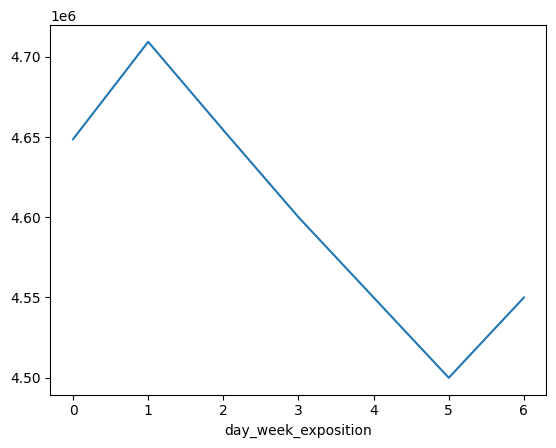

In [112]:
data_normal_day_week['median'].plot();

In [113]:
data_normal_month = data_normal.pivot_table(index='month_exposition', values='last_price', aggfunc=['count', 'median'])
data_normal_month.columns = ['count', 'median']
data_normal_month

,count,median
month_exposition,,
1,1249,4600000.0
2,2276,4650000.0
3,2265,4650000.0
4,2137,4750000.0
5,1120,4500000.0
6,1568,4400000.0
7,1461,4600000.0
8,1550,4600000.0
9,1812,4690000.0


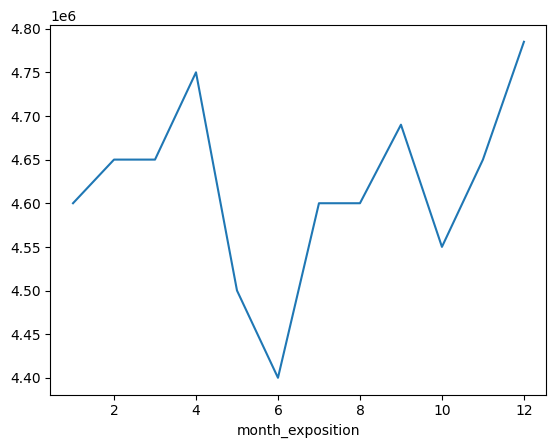

In [114]:
data_normal_month['median'].plot();

In [115]:
data_normal_year = data_normal.pivot_table(index='year_exposition', values='last_price', aggfunc=['count', 'median'])
data_normal_year.columns = ['count', 'median']
data_normal_year

,count,median
year_exposition,,
2014,123,7476560.0
2015,1023,5100000.0
2016,2495,4490000.0
2017,7268,4500000.0
2018,7326,4600000.0
2019,2597,5000000.0


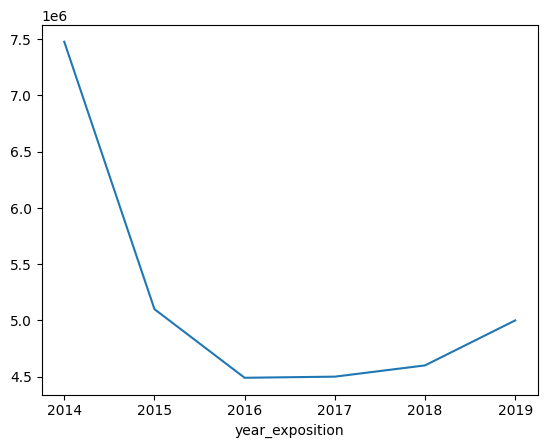

In [116]:
data_normal_year['median'].plot();

По коэффициентам корреляции можно сказать о полном отсутствии зависимости. По сгруппированным данным можно сказать следующее, зависимости стоимости от дня недели нет, но количество объявлений в 2 раза меньше размещают на выходных; также можно сказать про месяц размещения - зависимости от стоимости нет, но есть по количеству, меньше всего размещают объявлений в январе, мае и декабре.<br>
А вот с годами уже интереснее, самая высокая стоимость недвижимости была в 2014 году, но по этому году меньше всего объявлений. В 2017-2018 годах больше всего объявлений, почти в 3 раза больше, но по стоимости никакой разницы в период 2015-2019 годы, диапазон изменений стоимости недвижимости в 600 000 руб.

Мы провели исследование влияния некоторых параметров на стоимость недвижимости. На стоимость больше всего влияют: общая и жилая площади, чем они больше, тем дороже квартира соответственно. Также влияют такие параметры как: тип этажа - квартиры не на первом и последнем этажах дороже и год размещения объявления - в 2014 году была самая дорогая недвижимость.

## Средняя цена одного квадратного метра

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений, для этого построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов.

In [117]:
data_normal_city = data_normal.pivot_table(index='locality_name', values='price_metre', aggfunc=['count', 'median'])
data_normal_city.columns = ['count', 'median']
data_normal_city10 = data_normal_city.sort_values('count', ascending=False).head(10)
data_normal_city10.sort_values('median')

,count,median
locality_name,,
Выборг,198,58417.025
Всеволожск,356,65811.400
Гатчина,292,67860.570
Колпино,321,74722.220
поселок Шушары,396,77312.835
поселок Мурино,447,84146.340
деревня Кудрово,230,91499.170
поселок Парголово,289,92261.900
Пушкин,325,99744.250


Самая дорогая цена квадратного метра в Санкт-Петербурге, а самая дешевая - в Выборге.

## Средняя стоимость на разном удалении от центра

Выделим квартиры в Санкт-Петербурге и вычислим их среднюю стоимость на разном удалении от центра.

In [118]:
data_normal_Piter = data_normal\
    .query('locality_name == "Санкт-Петербург"')\
    .pivot_table(index='cityCenters_km', values='last_price', aggfunc=['median'])
data_normal_Piter.columns = ['median']
data_normal_Piter

,median
cityCenters_km,
0.0,11500000.0
1.0,9975000.0
2.0,9400000.0
3.0,8000000.0
4.0,8510000.0
5.0,8650000.0
6.0,8188000.0
7.0,7200000.0
8.0,7300000.0


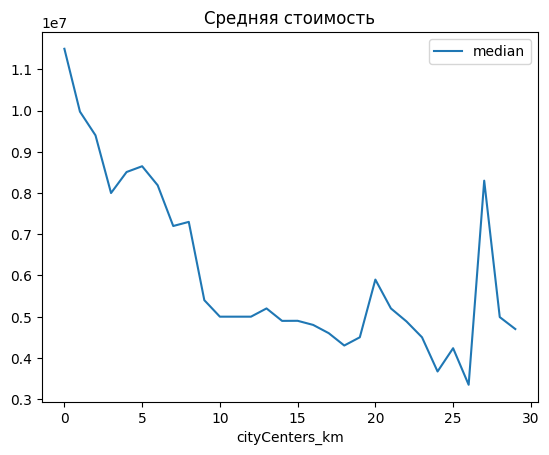

In [119]:
data_normal_Piter.plot(title='Средняя стоимость');

В общей картине наблюдается снижение стоимости при удалении от центра, за исключением нескольких всплесков в районе 4-5 км, 20 км и 27 км.

## Общий вывод


Мы изучили представленную информацию и привели её в состояние пригодное для плноценного анализа. <br>

Предобработка.<br>
Пропуски в столбцах:<br>
- 'floors_total' заполнили значениями из 'floor';
- 'ceiling_height' удалили аномальные значения;
- 'living_area' пропуски заполнили путем выведения соотношения общей площади к жилой;
- 'kitchen_area' пропуски не заполняли;
- 'locality_name' заменили неявные дубдикаты.<br>

Типы данных:<br>
- в стобцах 'floors_total', 'balcony', 'days_exposition' - изменили на тип данных int;
- в 'is_apartment' - на тип данных bool;
- 'first_day_exposition' - на тип данных datetime.<br>

Заполнение пропусков, а также изменение типов данных необходимо для применения нужных методов и функций при обработке данных для проведения анализа.<br>

Пропуски в данных могли появиться по нескольким причинам:<br>
- технологическая - данные для  'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest' получались автоматически из геоинформационных систем;<br>
- человеческий фактор - могли указать неправильные или ошибочные адреса.<br>

Далее после добавиления дополнительных столбцов с нужной для исследования информацией, приступили  к очистке и проведению исследовательского анализа данных:
- из 'total_area' удалили значения более 200 м;
- из 'living_area' удалили значения более 100 м;
- из 'kitchen_area' удалили значения менее 3 м и более 35 м;
- в 'last_price' обработали одно аномальное значение;
- из 'rooms' удалили квартиры в которых 6 и более комнат.

После обработки пропусков, дубликатов и аномальных значений в нашей выборке осталось 88% данных от исходной информации.<br>

Основное исследование.<br>
Мы провели исследование, в котором установили параметры, влияющие на цену объектов. На стоимость больше всего влияют: общая и жилая площади, чем они больше, тем дороже квартира соответственно. Также влияют такие параметры как: тип этажа - квартиры не на первом и не на последнем этажах дороже, год размещения объявления - в 2014 году была самая дорогая недвижимость.<br>

Выяснили, что по длительности продажа квартир обычно происходит в диапазоне 40 - 100 дней. Сделки менее 40 дней можно считать быстрой продажей, а более 600 дней, т.е. почти 2 года, уже необычно долгой продажей.<br>

Дополнительно выяснили, что самая дорогая цена квадратного метра в Санкт-Петербурге, а самая дешевая - в Выборге.<br>

Мы также узнали среднюю стоимость квартир при удалении от центра: в целом наблюдается снижение стоимости при удалении от центра, за исключением нескольких всплесков в районе 4-5 км, 20 км и 27 км. Вероятно, в этих районах располагаются элитные районы и населенные пункты.
Наше исследование позволяет построить автоматизированную систему, которая отследит аномалии и мошенническую деятельность.